# Permutation Method for Correlation Hypothesis Test

## Objectives

- To utilize the permutation method to conduct correlation hypothesis tests, assessing the significance of observed correlation coefficients.
- To understand the effect of reordering data elements on the calculated correlation coefficient.
- To compare permutation test results across different data types, from synthetic to real-world scenarios.

## Background

The permutation method for correlation hypothesis testing involves reordering one variable's data points while keeping another's fixed, thus creating a new sample distribution without replacement. This notebook demonstrates this non-parametric approach, which is especially useful when the assumptions required for traditional parametric tests are not met. The objective is to test the null hypothesis that there is no correlation (correlation coefficient equals zero) against the alternative that there is a non-zero correlation.

## Datasets Used

The datasets explored include a Synthetic Dataset created to demonstrate various correlation strengths, from strong to nonexistent, and two Real-World Datasets:
- Student Performance Dataset: It contains data on student grades to analyze correlations across different academic periods.
- IBM HR Analytics Employee Attrition & Performance Dataset: It analyzes employee data to explore correlations between tenure, salary, and commuting distance, providing insights into workforce dynamics.

## Introduction

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 8)

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  # set style

For the permutation test, the hypothesized population correlation coefficient is assumed to be zero and sampling is done WITHOUT replacement. 

Each sample pair now consists of all the elements in x in their original order together with the elements in y in random order. 

In [2]:
import itertools
from math import factorial

In [3]:
p3 = pd.Series(itertools.permutations([1,2,3]))
print(p3)
print('Number of permutations = %i' %p3.shape[0])

0    (1, 2, 3)
1    (1, 3, 2)
2    (2, 1, 3)
3    (2, 3, 1)
4    (3, 1, 2)
5    (3, 2, 1)
dtype: object
Number of permutations = 6


For an array of size 3, the number of permutation without repetition is:

In [4]:
factorial(3)

6

What happens when the size is bigger?

In [5]:
factorial(6)

720

In [6]:
factorial(10)

3628800

In [7]:
factorial(50)

30414093201713378043612608166064768844377641568960512000000000000

It is impossible to compute all possible permutations, even for sample sizes not so large, like 50. We will be working with a subset, 10000, for instance.

## The data

In [8]:
data = pd.read_csv('corrExamples.csv')
print(data.shape)
data.head()

(30, 7)


,x,y_spc,y_snc,y_wpc,y_wnc,y_nc,y_nc2
0,0.864861,5.966722,33.891055,20.747607,33.228954,60.257958,5.417415
1,-0.715509,2.660711,34.377933,22.650736,44.177148,61.157429,4.245928
2,0.978287,5.498195,33.150306,17.931824,27.620634,42.349386,4.987811
3,-2.018096,0.917615,35.761044,15.819973,38.082087,76.338343,8.017468
4,2.775647,7.935774,31.274222,31.112353,42.790156,38.697988,11.476520


## Computing the correlation

In [9]:
#np.corrcoef(grade_before, grade_after)[0][1]
np.corrcoef(data.x, data.y_spc)

array([[1.        , 0.98296946],
       [0.98296946, 1.        ]])

In [10]:
# Our statistic is the correlation coefficient between the two variables.
stat_r = np.corrcoef(data.x, data.y_spc)[0][1]
stat_r

0.9829694635784151

## Computing the sample distribution

For the permutation test, the hypothesized population correlation coefficient is assumed to be zero and sampling is done WITHOUT replacement. 

Each sample pair now consists of all the elements in x in their original order together with the elements in y in random order. 

In [11]:
def get_perm_sample_distribution_corr(x, y, num_samples=10000): 
    '''
    It returns a list with the correlation sample distribution.
    '''    
    x = np.array(x)
    y = np.array(y)    
    permutation_corrs = np.array([np.corrcoef(x, 
                                    np.random.permutation(y))[0, 1] 
                                    for _ in range(num_samples)])
    return permutation_corrs

In [12]:
#r_sample_distribution = permSampleDistribution(grade_before, grade_after)
sample_distribution_r = get_perm_sample_distribution_corr(data.x, data.y_spc)

Let's plot the sample distribution.

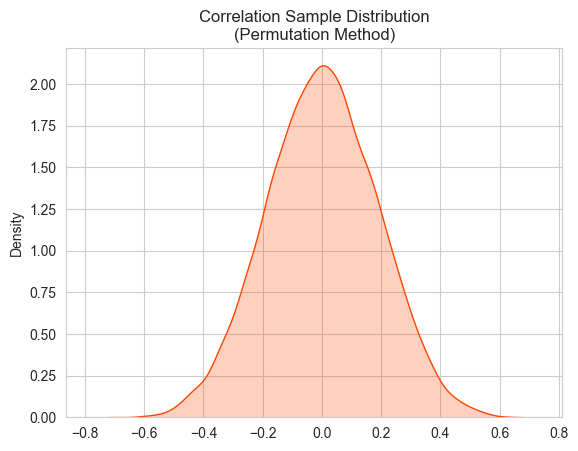

In [13]:
sns.kdeplot(sample_distribution_r, fill=True, color='orangered').set(
            title='Correlation Sample Distribution\n(Permutation Method)');

## The permutation hypothesis test for correlation

Let's use the `get_p_value` function we already know.

In [14]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):
    '''
    It returns the p-value.
    sample_distribution: the sample distribution
    obs_value:           observed value     
    alternative:         'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2 * min(ecdf(obs_value), 1-ecdf(obs_value))
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

Let's use the function: `graph_hyp_test_corr` to calculate the correlation coefficient's permutation hypothesis test.

In [15]:
def graph_hyp_test_corr(sample_value, sample_distribution, alpha=0.05):
    '''
    It calculates the resampling hypothesis test for correlation.
    sample_value:        statistic calculated from the sample
    sample_distribution: sample distribution calculated from the sample
    alpha:               significance level    
    '''
    print('--- Correlation Hypothesis Test ---')
    print('    Ho: r == 0')
    print('    Ha: r != 0')    
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='lightskyblue', fill=True)
    plt.title('Sampling Distribution for Correlation')
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)
    # calculating the p-value
    p_val = get_p_value(sample_distribution, sample_value)
    # plotting the critical regions
    cv1 = np.percentile(sample_distribution, (alpha/2)*100)         # left critical value  
    cv2 = np.percentile(sample_distribution, 100-(alpha/2)*100)     # right critical value  
    plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('    r = %.4f    p-value = %.4f' %(sample_value, p_val))

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.9830    p-value = 0.0000


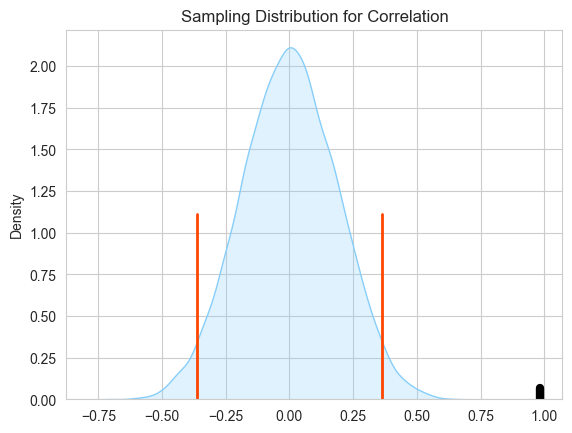

In [16]:
# Generated data with strong positive correlation
graph_hyp_test_corr(stat_r, sample_distribution_r)

p-value < 0.01 We are rejecting the null hypothesis!

There is a strong correlation between the two variables: `data.x` and `data.y_spc.` 

## Computing several correlation hypothesis tests

Let's create a function for computing the correlation between two variables.

In [17]:
def corr_permutation(x, y, num_samples=10000):
    '''
    It calculates the permutation hypothesis test for correlation.
    '''
    # computing the correlation (statistic)
    stat_r = np.corrcoef(x, y)[0][1]   
    # computing the sample distribution for correlation 
    sample_distribution_r = get_perm_sample_distribution_corr(x, y, num_samples=num_samples)    
    # plotting the hypothesis test
    graph_hyp_test_corr(stat_r, sample_distribution_r)

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.9496    p-value = 0.0000


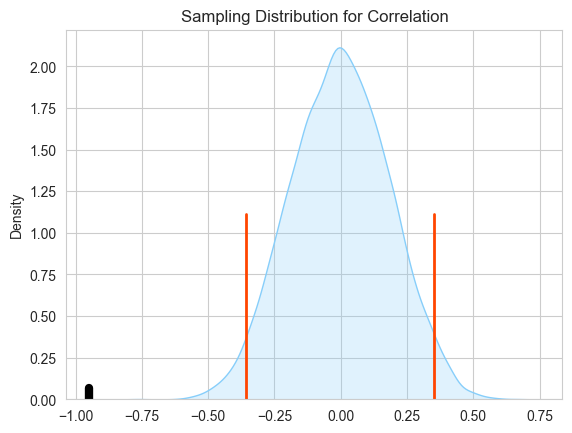

In [18]:
# Generated data with strong negative correlation
corr_permutation(data.x, data.y_snc)

The correlation value is -0.9496, and it is highly significant.

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.9496    p-value = 0.0000


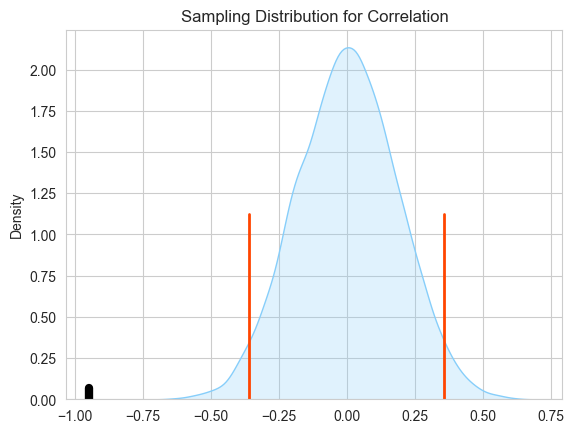

In [19]:
# Generated data with strong negative correlation
corr_permutation(data.x, data.y_snc)

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.3758    p-value = 0.0426


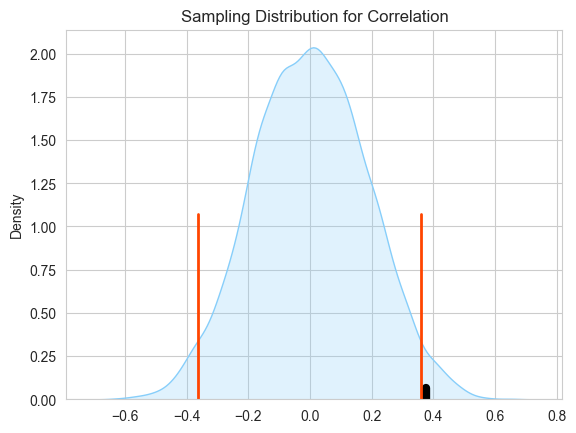

In [20]:
# Generated data with weak positive correlation
corr_permutation(data.x, data.y_wpc)

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.3743    p-value = 0.0392


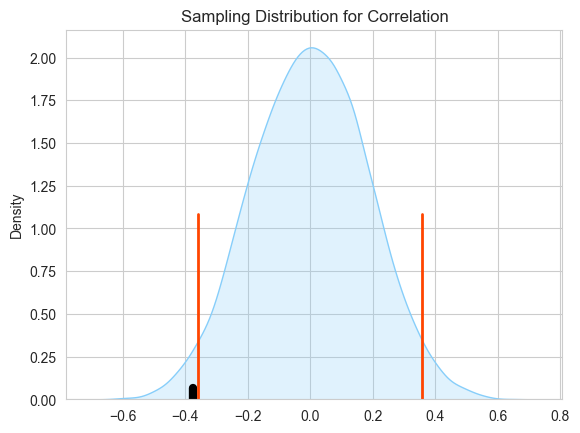

In [21]:
# Generated data with weak negative correlation
corr_permutation(data.x, data.y_wnc)

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.2328    p-value = 0.2166


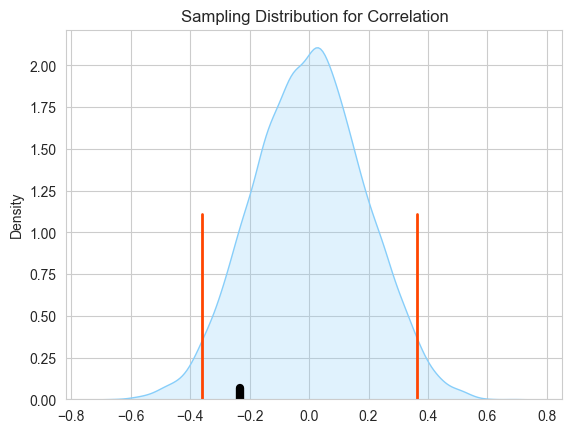

In [22]:
# Generated data with no correlation
corr_permutation(data.x, data.y_nc)

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.1414    p-value = 0.4510


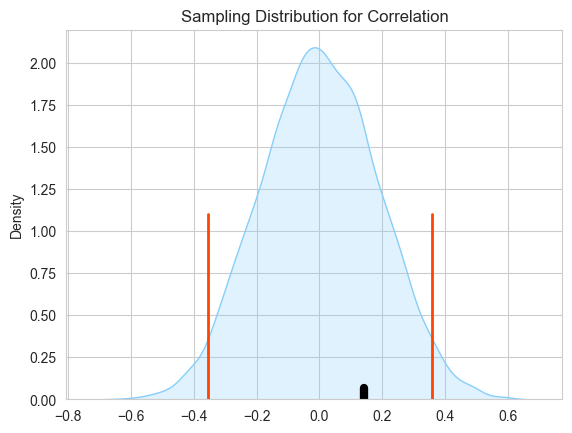

In [23]:
# Generated data with no correlation
corr_permutation(data.x, data.y_nc2)

## Real-world examples

Let's analyze some real-world examples.

### Student Performance Dataset

In [24]:
stp = pd.read_csv('student-mat.csv', sep=';')
print(stp.shape)
stp.head()

(395, 33)


,school,sex,age,address,...,absences,G1,G2,G3
0,GP,F,18,U,...,6,5,6,6
1,GP,F,17,U,...,4,5,5,6
2,GP,F,15,U,...,10,7,8,10
3,GP,F,15,U,...,2,15,14,15
4,GP,F,16,U,...,4,6,10,10


Let's work with the variables:

- **G1**: first period grade (numeric: from 0 to 20)
- **G2**: second period grade (numeric: from 0 to 20)
- **G3**: final grade (numeric: from 0 to 20, output target)

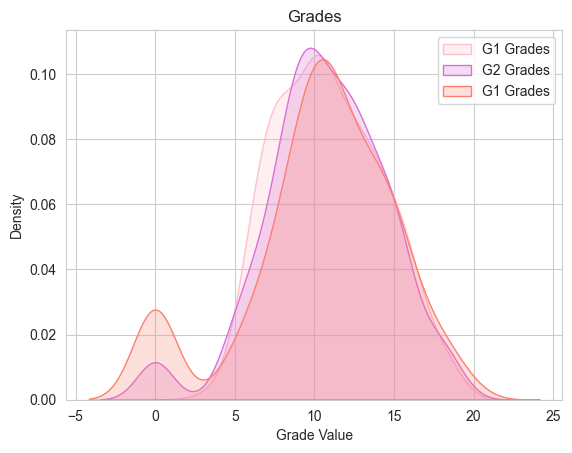

In [25]:
# kde plots for grades
sns.kdeplot(stp.G1, fill=True, color='pink',   label ='G1 Grades')
sns.kdeplot(stp.G2, fill=True, color='orchid', label ='G2 Grades')
sns.kdeplot(stp.G3, fill=True, color='salmon', label ='G1 Grades').set(title='Grades')
plt.xlabel('Grade Value')
plt.legend();

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.8521    p-value = 0.0000


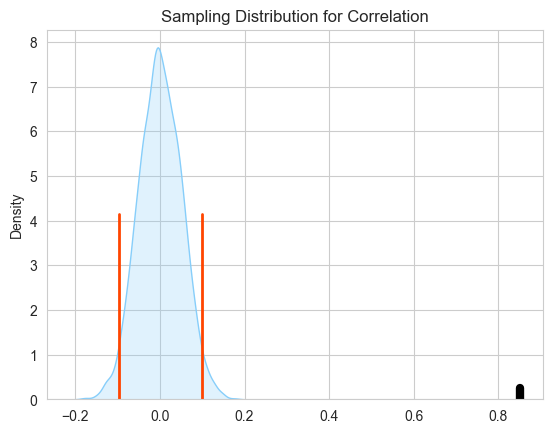

In [26]:
# Permutation correlation between G1 and G2
corr_permutation(stp.G1, stp.G2)

There is a positive correlation between the grades G1 and G2. It is highly significant!

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.9049    p-value = 0.0000


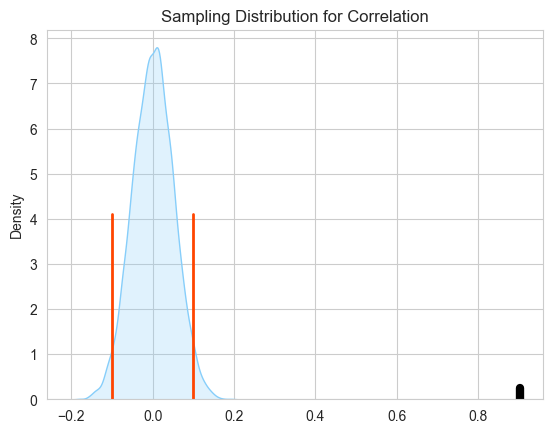

In [27]:
# Permutation correlation between G2 and G3
corr_permutation(stp.G2, stp.G3)

There is also a positive correlation between the grades G2 and G3. It is highly significant!

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.8015    p-value = 0.0000


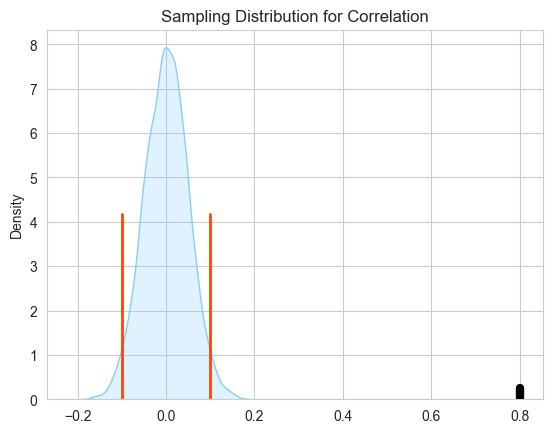

In [28]:
# Permutation correlation between G1 and G3
corr_permutation(stp.G1, stp.G3)

There is a positive significant correlation between all the pairs. The following plot corroborates it.

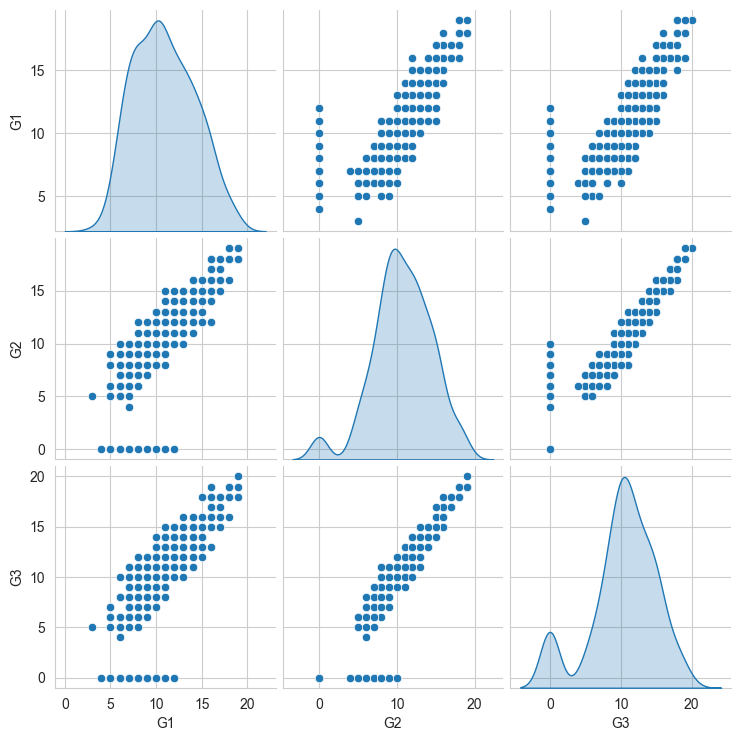

In [29]:
sns.pairplot(stp[['G1', 'G2', 'G3']], diag_kind='kde');

### IBM HR Analytics Employee Attrition & Performance Dataset

In [30]:
hr = pd.read_csv('HR-Employee-Attrition.csv')
print(hr.shape)
hr.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,...,6,4,0,5
1,49,No,Travel_Frequently,279,...,10,7,1,7
2,37,Yes,Travel_Rarely,1373,...,0,0,0,0
3,33,No,Travel_Frequently,1392,...,8,7,3,0
4,27,No,Travel_Rarely,591,...,2,2,2,2


This dataset has several variables, but we will be working with three of them:
- **YearsAtCompany**: years working at company
- **MonthlyIncome**: monthly income
- **DistanceFromHome**: distance from home

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.5143    p-value = 0.0000


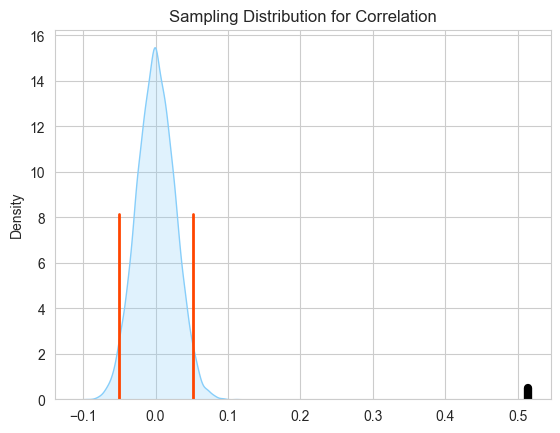

In [31]:
corr_permutation(hr.YearsAtCompany, hr.MonthlyIncome)

The years of work in the company are directly related to the worker's monthly salary.

--- Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0095    p-value = 0.6932


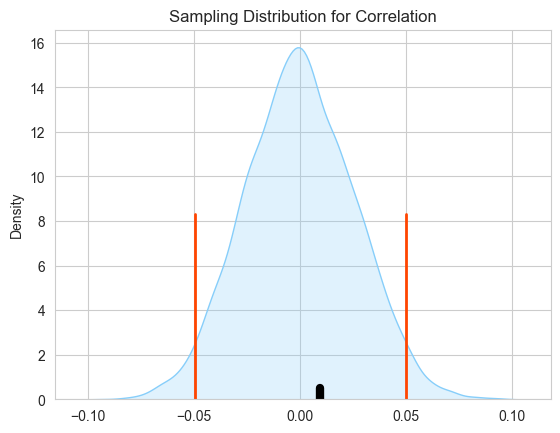

In [32]:
corr_permutation(hr.YearsAtCompany, hr.DistanceFromHome)

The years of work in the company do not depend on the distance the workers live.

## Conclusions

Key Takeaways:
- The permutation method effectively assesses correlation significance without relying on normality assumptions.
- Synthetic data correctly identified strong, weak, and no correlations, illustrating the method's reliability across different scenarios.
- Real-world applications to student performance and employee datasets confirmed significant correlations between grades, tenure, and salary but not between tenure and commuting distance.
- The method proves robust and versatile for educational and professional settings where traditional assumptions may not exist.

## References


- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 4.